# **Objetivo del Cuaderno Jupyter**
- Análisis de las variables, para decantarnos por las que aportan valor y/o características de diferenciación al modelo, sin caer en la redundancia.
- Aplicación de las técnicas provistas por la Libreria `sklearn` para el preprocesamiento de las variales y posterior obtención del Modelo.
- De lo obtenido en el punto anterior, se procediú a extraer `únicamente la data requerida` con el fin de hacer factible su despliegue en Render.
- Como ultima parte de este Cuaderno, en el titulo `Como Funcionaría el Sistema de Recomendación`, está la opción de probar el modelo dentro del cuaderno 

In [1]:
import pandas as pd
import ast
import polars as pl
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import numpy as np

In [1]:
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import TruncatedSVD

### **Descarguemos el Archivo obtenido de ejecutar los 3 Cuadernos Anteriores**

In [6]:
import gdown

url = 'https://drive.google.com/uc?export=download&id=17xfj01E-HPMYQbarzXdakFBoJNuPZ5OP'

gdown.download(url, 'data/movies_modelar.parquet', quiet=False)


Downloading...
From: https://drive.google.com/uc?export=download&id=17xfj01E-HPMYQbarzXdakFBoJNuPZ5OP
To: d:\BOOTCAMP-HENRY\MODULO-07-LABS\data\movies_modelar.parquet
100%|██████████| 9.95M/9.95M [00:08<00:00, 1.17MB/s]


'data/movies_modelar.parquet'

In [2]:
movies = pl.read_parquet('data/movies_modelar.parquet')

### **Verificacion de Filas Repetidas**
- Verificaremos que no hay filas repetidas en el dataframe `movies`, pero mas que verificar que no haya registros o filas repetidas, pienso que acá lo más importante es verificar que no haya `id` de movies repetidos.  Pensar que existe la posibilidad de encontrar Peliculas con el mismo `id` y que la fila no esté repetida porque dichas filas tengan diferentes cualquier otro campo.  Pero de no haber `id` repetidos automaticamente NO HAY FILAS REPETIDAS

In [4]:
print(f'Cantidad de Registros en el Dataframe "movies" --> {movies.shape[0]}')
print(f'Cantidad de Registros sin tener "id" repetido --> {movies["id"].unique().shape[0]}')

Cantidad de Registros en el Dataframe "movies" --> 44898
Cantidad de Registros sin tener "id" repetido --> 44898


**Nota:** Tomar en Cuenta que la data ha venido limpiandose y transformandose a lo largo de 3 Cuadernos Jupyter

### **Empezando a Limpiar Variables**
**Las siguientes Variables tienen que ver con fechas:**
- `release_year`
- `release_month`
- `release_day_of_week`
- `name_of_month`
- `name_of_day`
- `release_date`

- De todas estas me quedaré con `release_year` (que es el año de estreno de la pelicula), quiero que el modelo encuentre coincidencias con esta variable mas que con la fecha `release_date`, (por redundancia NO LAS PUEDO DEJAR LAS 2), pero para el criterio humano a la hora de escoger una pelicula, pesa mas el año que la fecha exacta. Igual pasa con las variables.  

**Las siguientes Variables tienen que ver con el idioma**
- `original_language`
- `spoken_languages`
- En los casos de las Películas donde se habla un solo idioma tienen la misma informacion, por el mismo punto anterior, mequedaré solo con `original_languages`

**VARIABLES QUE CREO IMPORTANTES, PERO EL PODER DE COMPUTO ME OBLIGO A ELEGIR** 
- `overview`
- `actores`
- Aca el punto es que la data preprocesada, antes de correr el modelo, de estas variables son las mas PESADAS, con una diferencia sobre las otras Variables de 50:1 y 100:1, donde traté de correr el modelo con ambas, incluso  limitandome solo a peliculas en Ingles y Español (Algo mas de 26000 Filas) y ni colab ni mi computador pudieron. Me quedé con `actores`.

In [3]:
columns_to_delete = ['release_date', 'release_month', 'release_day_of_week', 'name_of_month', 'name_of_day', 'id', 'overview', 'spoken_languages']
movies = movies.drop(columns_to_delete)

### **Tenemos varios tipos de Variables**:
- Variables que representan un valor Númerico `Grupo 1`
    - `budget`
    - `popularity`
    - `revenue`
    - `runtime`
    - `vote_average`
    - `vote_count`
    - `return`
    - `release_year`
- Variables que aunque tienen un Valor númerico no representan un número, sino que son un codigo o id, que los identifica (normalmente eran String, pero por la normalizacion quedaron numericas)  `Grupo 2`
    - `original_languages`:  id que representa el idioma
    - `director`:  id que representa el director
- Variables String `Grupo 3`
    - `status`
    - `tagline`
    - `title`
- Variables que aunque esten (por ahora) como String son en realidad una Lista de Enteros.  Un ejemplo es la columa de generos, al poder pertenecer una pelicula a varios generos hay una lista con los id de cada uno `Grupo 4`
    - `belongs_to_collection`
    - `genres`
    - `production_companies`
    - `production_countries`
    - `actores`    

## **Valores Nulos y Faltantes**<br>
Recordar que la data fue extraída con funciones que leían los `csv` caracter a caracter como si fueran textos, y armaban Listas de diccionarios donde todos los esquemas coincidian y donde los valores NULOS de los dataset fueron transformados a "".  Por lo que las funciones de `Pandas` o `Polars` para detectar valores NULOS o NAN aca NO APLICAN. <br>
**Nota**: Igual en las siguientes celdas se aplicará la sintáxis para detectar Nulos por parte de los dataframes y verá que los resultados son 0. Por lo que para cada Tipo de Variable se aplica un estudio distinto

**Analicemos** Variables pertenecientes a los `Grupos 1 y 2`

In [4]:
columns = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average',
           'vote_count', 'return', 'release_year', 'original_language']
for column in columns:
    print(f'COLUMNA ----------> {column}')
    mask = movies[column].is_null()
    print(f'Cantidad de Nulos --> {movies.filter(mask).shape[0]}')
    mask = movies[column] == 0
    print(f'Numero de CEROS   --> {movies.filter(mask).shape[0]}')
    print('*'*50)

COLUMNA ----------> budget
Cantidad de Nulos --> 0
Numero de CEROS   --> 36089
**************************************************
COLUMNA ----------> popularity
Cantidad de Nulos --> 0
Numero de CEROS   --> 40
**************************************************
COLUMNA ----------> revenue
Cantidad de Nulos --> 0
Numero de CEROS   --> 37550
**************************************************
COLUMNA ----------> runtime
Cantidad de Nulos --> 0
Numero de CEROS   --> 1771
**************************************************
COLUMNA ----------> vote_average
Cantidad de Nulos --> 0
Numero de CEROS   --> 2897
**************************************************
COLUMNA ----------> vote_count
Cantidad de Nulos --> 0
Numero de CEROS   --> 2801
**************************************************
COLUMNA ----------> return
Cantidad de Nulos --> 0
Numero de CEROS   --> 39560
**************************************************
COLUMNA ----------> release_year
Cantidad de Nulos --> 0
Numero de CEROS   --> 0

**Analicemos** las variables del `Grupo 3`

In [5]:
# columns = ['overview', 'status', 'tagline', 'title']
columns = ['status', 'tagline', 'title']

for column in columns:
    print(f'COLUMNA ----------> {column}')
    mask = movies[column].is_null()
    print(f'Cantidad de Nulos     --> {movies.filter(mask).shape[0]}')
    mask = movies[column] == ""
    print(f'Numero de Faltantes   --> {movies.filter(mask).shape[0]}')
    print('*'*50)


COLUMNA ----------> status
Cantidad de Nulos     --> 0
Numero de Faltantes   --> 78
**************************************************
COLUMNA ----------> tagline
Cantidad de Nulos     --> 0
Numero de Faltantes   --> 24753
**************************************************
COLUMNA ----------> title
Cantidad de Nulos     --> 0
Numero de Faltantes   --> 0
**************************************************


**Analicemos** `Grupo 4`

Como son String que representan Listas, tomar en cuenta que aca un valor faltante, ademas de `""`, también son aquellos campos que contengan `"[]"`

In [6]:
# columns = ['belongs_to_collection', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'actores']
columns = ['belongs_to_collection', 'genres', 'production_companies', 'production_countries', 'actores']
for column in columns:
    print(f'COLUMNA ----------> {column}')
    mask = movies[column].is_null()
    print(f'Cantidad de Nulos     --> {movies.filter(mask).shape[0]}')
    mask = (movies[column] == "") | (movies[column] == "[]")
    print(f'Numero de Faltantes   --> {movies.filter(mask).shape[0]}')
    print('*'*50)

COLUMNA ----------> belongs_to_collection
Cantidad de Nulos     --> 0
Numero de Faltantes   --> 40447
**************************************************
COLUMNA ----------> genres
Cantidad de Nulos     --> 0
Numero de Faltantes   --> 2352
**************************************************
COLUMNA ----------> production_companies
Cantidad de Nulos     --> 0
Numero de Faltantes   --> 11654
**************************************************
COLUMNA ----------> production_countries
Cantidad de Nulos     --> 0
Numero de Faltantes   --> 6127
**************************************************
COLUMNA ----------> actores
Cantidad de Nulos     --> 0
Numero de Faltantes   --> 2312
**************************************************


Las columnas con `muchos valores nulos y/o faltantes` deben ser eliminadas para no crear similitudes inexistentes.
- `budget`
- `revenue`
- `return`
- `tagline`
- `production_companies`
- `belongs_to_collection`

In [7]:
columns_to_delete = ['budget', 'revenue', 'return', 'tagline', 'production_companies', 'belongs_to_collection']
movies = movies.drop(columns_to_delete)

**Analizando la Variable `status `**

In [10]:
movies['status'].value_counts()

status,count
str,u32
"""In Production""",19
"""Rumored""",228
"""Released""",44463
"""""",78
"""Post Production""",96
"""Planned""",13
"""Canceled""",1


### **Consideraciones de variable `status` y otras**
- Sobre la variable `status`. No podemos recomendar algo `rumoreado` o `cancelado` o etc... pienso que debemos seleccionar solo las que tengan status de `Released` o `Post Produccion` y despues borrar la columna, porque la informacion útil de esta columna era el descarte completo de registros de peliculas que no se van a hacer, o no se han echo todavia, o son solo un rumor del medio artístico, etc.

- Al ser un modelo de recomendacion basado en contenido, dado que no existe un historal de busqueda del usuario, se va a plantear un modelo que estudie similitudes de los datos. El tener blancos o ceros, va a crear vectores que representen esos blancos y ceros y tenderá a confundir al modelo.

- Por lo expuesto anteriormente voy a borrar los registros con valores `Nulos o Vacios`.

- Despues de Limpiar la data de Nulos y Faltantes habrá que hacer un estudio de correlaciones, etc para ver que columnas son las realmente importantes y tomarlas en cuenta sólo a ellas.

- Las columnas como `vote_count` o `vote_average` asumiré que si pueden ser `0`, ya que es posible que Nadie haya dado una valoracion a una pelicula mala, o aburrida, o que este muy nueva todavía.

- Sin embargo eliminaré los registros cuya `popularity` sea 0, ya que esta puntuación es otrogada por un Organismo el `TMDB (The Movies Data Base)`, entonces lo mas seguro es que sea un dato faltante

In [8]:
deneid_status = ["Rumored", "In Production", "Planned", "Canceled", ""]

mask = (movies['genres'] == "[]") | (movies['genres'] == "") | \
       (movies['actores'] == "[]") | (movies['actores'] == "") |\
       (movies['production_countries'] == "[]") | (movies['production_countries'] == "") |\
       (movies['actores'] == "[]") | (movies['actores'] == "") |\
       (movies['original_language'] == 0) | \
       (movies['runtime'] == 0) | \
       (movies['director'] == 0) | \
       (movies['popularity'] == 0) | \
       (movies['release_year'] == 0) | \
       (movies['status'].is_in(deneid_status)) | \
       (~movies['original_language'].is_in([20, 91]) ) # Me quedo solo con Ingles y Español


"""
CODIGOS DE IDIOMAS
20 --> Ingles
57 --> Portugues
91 --> Español
94 --> Italiano
etc...
"""

# Observando que cantidad de información me va a quedar de aplicar todos los filtros de arriba
movies.filter(~mask).shape[0]

26006

#### **Me quedaran algo mas de 26000 registros con datos en todos los campos (lo cual es recomendable para un modelo que busca similitud).  Procedemos a aplicar los cambios (el filtrado de las filas)**

In [9]:
movies = movies.filter(~mask)

# Aprovecho de Borrar 'status'
movies = movies.drop('status')

movies.head(1)

genres,original_language,popularity,production_countries,runtime,title,vote_average,vote_count,release_year,director,actores
str,i32,f32,str,f32,str,f32,i32,i32,i32,str
"""[16, 35, 10751]""",20,21.946943,"""[96]""",81.0,"""Toy Story""",7.7,5415,1995,7879,"""[8873, 31, 7167, 12900, 12903,…"


### **Analicemos sí la variable Año (`release_year`) nos dice algo**

In [13]:
"""
Necesito un dataframe pequeño de solo 2 columnas
`rango`             -> El contenido de la Variable `labels` ira en es columna
`cantidad_pelicula` -> Se filtrará a `movies` por cada rango de la variable `rangos`
                       y se obtiene el shape
"""

labels = ['1874-1930', '1931-1940', '1941-1950', '1951-1960', '1961-1970',
          '1971-1980', '1981-1990', '1991-2000', '2001-2010', '2011-2020']

rangos = [[1874,1930], [1931,1940], [1941,1950], [1951,1960], [1961,1970],
          [1971,1980], [1981,1990], [1991,2000], [2001,2010], [2011,2020]]

data = []
for j in range(len(rangos)):
    mask = movies['release_year'].is_between(rangos[j][0], rangos[j][1])
    data.append(movies.filter(mask).shape[0])

rangos_dic = {'rangos': labels, 'cantidad_peliculas': data}

rangos_df = pl.DataFrame(data=rangos_dic)

fig = px.bar(rangos_df, x='rangos', y='cantidad_peliculas',
             labels={'rango': 'Rango de Años', 'cantidad_peliculas': 'Cantidad de Películas'},
             title='Cantidad de Películas Estrenadas por Rango de Años')
fig.show()

Aparetemente las dos últimas dedacas ha sido el BOOM de la producción de películas. La pequeña diferencia entre 2011-2020  y 2001-2010  pudo deberse a que en 2020 hubo Pandemia. El año de la película la pienso conservar, pensemos que existen personas con gustos `retro` ó peliculas `Mexicanas antiguas`, etc, este dato ayuda a diferenciar tomando en cuenta este dato.

***
### **Analicemos sí la variable Año (`runtime`) nos dice algo**

In [10]:
fig = px.box(movies, y='runtime', title='Distribución de la Duración de las Películas',
             labels={'runtime': 'Duración (minutos)'})

# Mostrar el gráfico
fig.show()

Aunque está todo tan amontonado sí pasamos el mouse, por lo que debería ser la caja en la imagen, se ven la `mediana`, `cuartiles`, `bigotes`, `etc`. Acá lo que veo mas interesante es que las duraciones van desde `1 minuto` hasta `1256 minutos`. Pudiera ser que no sean sólo peliculas.  Es probable que en la data haya `trailers de promoción`, `cortometrajes`, `peliculas` y `series`. Pero todavía no es claro

In [11]:
# Aca se muestran la cantidad de titulos por arriba y por debajo de LOS BIGOTES del boxplot
mask = (movies['runtime'] > 134)
print(f'Cantidad de peliculas con duracion mayor a 134 minutos --> {movies.filter(mask).shape[0]}')
mask = (movies['runtime'] < 59)
print(f'Cantidad de peliculas con duracion menor a 59 minutos --> {movies.filter(mask).shape[0]}')

Cantidad de peliculas con duracion mayor a 134 minutos --> 1138
Cantidad de peliculas con duracion menor a 59 minutos --> 935


In [12]:
fig = px.histogram(movies, x='runtime', nbins=30, title='Distribución de la Duración de las Películas',
                   labels={'runtime': 'Duración (minutos)'})

# Mostrar el gráfico
fig.show()

Tampoco muestra mucho.  Vamos a poner LUPA en los supuestos `outliers`

In [13]:
movies[['runtime', 'title', 'release_year']].sort('runtime', descending=True).head()

runtime,title,release_year
f32,str,i32
1256.0,"""Centennial""",1978
900.0,"""The Story of Film: An Odyssey""",2011
877.0,"""Taken""",2002
874.0,"""The War""",2007
840.0,"""The Roosevelts: An Intimate Hi…",2014


**Extraido de Wikipedia**<br>
`Centennial` (Centenario), es una serie del género épico estadounidense para la televisión que incluye un gran elenco de artistas, está basada en la novela homónima épica de James A. Michener. Fue emitida entre `1978` y 1979 y está basada en la conquista del Oeste estadounidense, describiendo las vivencias de una generación de exploradores y sus vástagos que contribuyeron con sus vivencias a poblar la llamada frontera. Abarca cronológicamente desde 1795 hasta 1970 iniciándose en las inmediaciones de St. Louis. 

**Conclusion** NO SON outliers. `runtime` es una variable IMPORTANTE PARA QUE EL MODELO DIFERENCIE `peliculas` `series`, `cortometrajes`, etc.  Es lógico que hayan muchas mas peliculas que seríes y por eso distorcionan las imagenes en los gráficos porque alargan mucho la escala

***
### **Analicemos en graficos las relaciones entre `vote_count`, `vote_average` y `popularity`**


In [14]:
# RELACION vote_count  vs  vote_average
fig1 = px.scatter(movies, x='vote_count', y='vote_average',
                  title='Vote Count vs Vote Average',
                  labels={'vote_count': 'Vote Count', 'vote_average': 'Vote Average'})
fig1.show()

# RELACION vote_count  vs  popularity
fig2 = px.scatter(movies, x='vote_count', y='popularity',
                  title='Vote Count vs Popularity',
                  labels={'vote_count': 'Vote Count', 'popularity': 'Popularity'})
fig2.show()

# RELACION popularity vs vote_average
fig3 = px.scatter(movies, x='popularity', y='vote_average',
                  title='Popularity vs Vote Average',
                  labels={'popularity': 'Popularity', 'vote_average': 'Vote Average'})
fig3.show()

# BOXPLOT popularity
fig4 = px.box(movies, y='popularity', title='Distribución de Popularity',
              labels={'popularity': 'Popularity'})
fig4.show()

# BOXPLOT vote_average
fig5 = px.box(movies, y='vote_average', title='Distribución de Vote Average',
              labels={'vote_average': 'Vote Average'})
fig5.show()

# BOXPLOT vote_count
fig6 = px.box(movies, y='vote_count', title='Distribución de Vote Count',
              labels={'vote_count': 'Vote Count'})
fig6.show()

Aparentemente hay muchos `outliers` pero apliquemos una Lupa a esas columnas específicamente, con listados Top (Ordenados por cada una de las caracteristicas)

In [15]:
# Ordenado por `vote_count`

movies[['title', 'vote_count', 'vote_average', 'popularity']].sort('vote_count', descending=True).head(10)

title,vote_count,vote_average,popularity
str,i32,f32,f32
"""Inception""",14075,8.1,29.108149
"""The Dark Knight""",12269,8.3,123.167259
"""Avatar""",12114,7.2,185.070892
"""The Avengers""",12000,7.4,89.88765
"""Deadpool""",11444,7.4,187.860489
"""Interstellar""",11187,8.1,32.213482
"""Django Unchained""",10297,7.8,19.785025
"""Guardians of the Galaxy""",10014,7.9,53.291599
"""Fight Club""",9678,8.3,63.869598


In [16]:
# Ordenado por Popularity

movies[['title', 'vote_count', 'vote_average', 'popularity']].sort('popularity', descending=True).head(10)

title,vote_count,vote_average,popularity
str,i32,f32,f32
"""Minions""",4729,6.4,547.488281
"""Wonder Woman""",5025,7.2,294.337036
"""Beauty and the Beast""",5530,6.8,287.253662
"""Baby Driver""",2083,7.2,228.032745
"""Big Hero 6""",6289,7.8,213.849915
"""Deadpool""",11444,7.4,187.860489
"""Guardians of the Galaxy Vol. 2""",4858,7.6,185.330994
"""Avatar""",12114,7.2,185.070892
"""John Wick""",5499,7.0,183.870377


In [17]:
# Ordenado por `vote_average`
movies[['title', 'vote_count', 'vote_average', 'popularity']].sort('vote_average', descending=True).head(10)

title,vote_count,vote_average,popularity
str,i32,f32,f32
"""Reckless""",1,10.0,0.119713
"""Girl in the Cadillac""",1,10.0,0.405392
"""The Haunted World of Edward D.…",1,10.0,0.037443
"""Dancer, Texas Pop. 81""",1,10.0,0.567444
"""Stiff Upper Lips""",1,10.0,0.882132
"""Common Threads: Stories from t…",2,10.0,0.544277
"""High Roller: The Stu Ungar Sto…",1,10.0,0.888157
"""Li'l Abner""",1,10.0,0.611118
"""Blessed Event""",1,10.0,0.090803


In [18]:
# Ordenado por vote_average, pero filtrando que tengan al menos 2000 valoraciones

mask = movies['vote_count'] > 2000
movies.filter(mask)[['title', 'vote_count', 'vote_average', 'popularity']].sort('vote_average', descending=True).head(10)

title,vote_count,vote_average,popularity
str,i32,f32,f32
"""The Shawshank Redemption""",8358,8.5,51.645405
"""The Godfather""",6024,8.5,41.109264
"""Pulp Fiction""",8670,8.3,140.950241
"""Schindler's List""",4436,8.3,41.725124
"""One Flew Over the Cuckoo's Nes…",3001,8.3,35.529552
"""Psycho""",2405,8.3,36.826309
"""The Godfather: Part II""",3418,8.3,36.629307
"""Fight Club""",9678,8.3,63.869598
"""The Dark Knight""",12269,8.3,123.167259


#### **Analisis preliminar de  `vote_count`, `vote_average`, `popularity`**
- Lo mastrado no es suficiente para sacar conclusiones (pero si da una idea)
- Por lo mostrado (sobretodo en los listados), la mayor correlacion es entre `vote_count` y `popularity`, pero no hay una linealidad tan clara como tal. En los listados top de `vote_count` y `popularity` se observan coincidencias. Probablemente habrá que eliminar una de estas 2 variables para evitar redundar
- `vote_average` es una variable peligrosa para el analisis (a primera vista, y dejandola asi como está).  Las películas con los valores mas altos de esta variable tienen una sola valoracion.  Pero por otra parte al filtrar que hubiesen mas de 2000 valoraciones los  top no coincidian  con los top de las otras dos categorias, lo cual que puede ser una variable diferenciadora.
- Hay que esperar un análisis de correlación, pero no suena descabellado unir estas variable en una sola (por medio de una reducción de dimensionalidad o cualquier otra técnica), Así evitamos la redundancia que pudiera haber entre `vote_count` y `popularity` y conservamos lo diferenciador de `vote_average`, sin el sesgo a pelicula de pocas valoraciones. 

#### **Como ultimo cambio en Polars pasemos a mayuscula `title`**

In [19]:
movies = movies.with_columns(pl.col('title').str.to_uppercase())

In [20]:
movies.head(1)

genres,original_language,popularity,production_countries,runtime,title,vote_average,vote_count,release_year,director,actores
str,i32,f32,str,f32,str,f32,i32,i32,i32,str
"""[16, 35, 10751]""",20,21.946943,"""[96]""",81.0,"""TOY STORY""",7.7,5415,1995,7879,"""[8873, 31, 7167, 12900, 12903,…"


***
### Hora de pasar a Pandas
**Motivos**:
- Pandas cuando hace el análisis de correlación muestra los nombres de las variables (Polars muestra el indice de columna), es menos amigable a la vista
- Pandas está MUCHO MAS compenetrada con Sckit Learn, en comparación con Polars. (Razon Fundamental del cambio)

In [21]:
movies_df = movies.to_pandas()
movies_df.head(1)

,genres,original_language,popularity,production_countries,runtime,title,vote_average,vote_count,release_year,director,actores
0,"[16, 35, 10751]",20,21.946943,[96],81.0,TOY STORY,7.7,5415,1995,7879,"[8873, 31, 7167, 12900, 12903, 1116442, 12899,..."


Las Variables que ahora estan como String, que guardan informacion de codigos o id de generos, actores, etc, las pasaremos a Listas de enteros

In [22]:
column_list = ['genres', 'production_countries', 'actores' ]

def convert_and_sort(val: str) -> list:
    """convert_and_sort Recibe una cadena y devuelve una lista
                        el interior de la cadena cumple con la
                        sintaxis correcta de la lista.
                        luego de convertirla la ordena
    Args:
        val (str): cadena que recibe
    Returns:
        list: Lista producto de la conversion y ordenamiento
    """
    lista = ast.literal_eval(val)
    lista.sort()
    return lista

for column in column_list:
    movies_df[column] = movies_df[column].apply(convert_and_sort)

### **Matriz correlacion Variables Numericas**

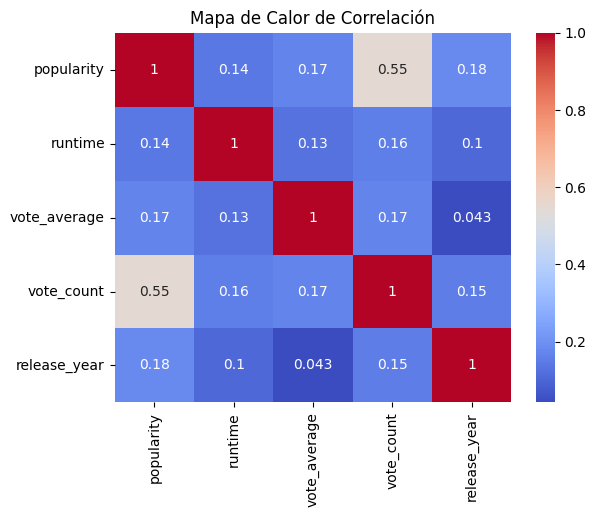

In [38]:
# Calcular la matriz de correlación
correlation_matrix = movies_df[['popularity', 'runtime', 'vote_average', 'vote_count', 'release_year']].corr()

# Crear el mapa de calor
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Mapa de Calor de Correlación')
plt.show()

Nota: `vote_count` y `popularity` son las que mas se correlacionan. Sigo con la idea de reducir dimencionalidad con estas 2 variables mas `vote_average`.

***
# **Preprocesamiento de Datos**

In [24]:
# Preprocesando variables categóricas -> aquellas que tenian un `id` directo de lo que representaban
le = LabelEncoder()
movies_df['original_language'] = le.fit_transform(movies_df['original_language'])
movies_df['director'] = le.fit_transform(movies_df['director'])

# Preprocesando variables de lista de enteros
mlb = MultiLabelBinarizer(sparse_output=True)
genres = mlb.fit_transform(movies_df['genres'])
production_countries = mlb.fit_transform(movies_df['production_countries'])
actores = mlb.fit_transform(movies_df['actores'])

# NOTA: ACA IBA el Preprocesamiento de `Overview`, pero no Hubo Poder de computo, y me decanté por Actores
# Preprocesando la variable de texto (overview)
# vectorizer = TfidfVectorizer(stop_words='english')
# overview_vectorized = vectorizer.fit_transform(movies_df['overview'])

# Reducir dimensionalidad de las matrices binarias y TF-IDF
svd_genres = TruncatedSVD(n_components=min(100, genres.shape[1] - 1))
svd_production_countries = TruncatedSVD(n_components=min(100, production_countries.shape[1] - 1))
svd_actores = TruncatedSVD(n_components=min(100, actores.shape[1] - 1))
# Aca igual la linea de abajo era para la variable `overview`
# svd_overview = TruncatedSVD(n_components=100)

genres_reduced = svd_genres.fit_transform(genres)
production_countries_reduced = svd_production_countries.fit_transform(production_countries)
actores_reduced = svd_actores.fit_transform(actores)
# Aca igual la linea de abajo era para la variable `overview`
# overview_reduced = svd_overview.fit_transform(overview_vectorized)

# Combinar todas las características preprocesadas
preprocessed_data = np.hstack((
    genres_reduced,
    production_countries_reduced,
    actores_reduced,
    # Aca igual la linea de abajo era para la variable `overview`
    # overview_reduced,
    movies_df[['original_language', 'popularity', 'runtime', 'vote_average', 'vote_count', 'release_year', 'director']].values
))

print(type(preprocessed_data))


<class 'numpy.ndarray'>


## **Aplicar PCA a `popularity`, `vote_count` y `vote_average`**

In [ ]:
# Seleccionar las variables numéricas
numeric_features = movies_df[['popularity', 'vote_count', 'vote_average']]

# Aplicar PCA
pca = PCA(n_components=2)
numeric_pca = pca.fit_transform(numeric_features)


## **Crear el Modelo**

In [26]:
# Combinar todas las características preprocesadas
combined_features = np.hstack((numeric_pca, preprocessed_data))

# Calcular la similitud del coseno
cosine_sim = cosine_similarity(combined_features, combined_features)


In [27]:
def get_top_similarities(cosine_sim, top_n=5):
    top_similarities = []
    for i in range(cosine_sim.shape[0]):
        sim_scores = list(enumerate(cosine_sim[i]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        top_similarities.append(sim_scores[1:top_n+1])
    return top_similarities

# Obtener las similitudes más relevantes
top_similarities = get_top_similarities(cosine_sim)

# Guardar las similitudes más relevantes
# joblib.dump(top_similarities, 'model/top_similarities.pkl')

## **Salvar el Modelo y la Data**

In [28]:
# Guardar las similitudes más relevantes
joblib.dump(top_similarities, 'model/top_similarities.pkl')
# joblib.dump(top_similarities, 'top_similarities.pkl')

movies_df.to_parquet('model/movies_modelo.parquet', index=False)
# movies_df.to_parquet('movies_modelo.parquet', index=False)

## **Reduciendo el Tamaño del Dataframe**


In [ ]:
movies_df['title'].to_clipboard() # Mando el df solo con titulos a memoria (^C)

movie_reducido = pl.read_clipboard() #Recojo el df que está en Memoria (^V)

# Polars no maneja indice como pandas. Le creo la columna index
movie_reducido = movie_reducido.with_row_index(name="index", offset=0)

movie_reducido.write_parquet('model/movies_model_polars.parquet')

## **¿Que fue lo que ocurrió de Preprocesamiento hasta aca?**<br>

Teníamos un Dataframe que contenía las Variables Predictoras seleccionadas y lo introdujimos en una especie de caja de magia llamada Sklearn<br>

<img src='assets/explica_modelo_01.png'><br>

Sklearn Generosamente nos devuelve una matriz GIGANTE llamada `cosine_sim`<br>

<img src='assets/explica_modelo_02.png'><br>

Donde `cosine_sim` tiene 26006 listas internas.  El orden de estas listas internas coincide con el orden de los titulos en el Dataframe, es decir la primera lista interna, refleja informacion de la pelicula que aparece de primero en el Dataframe (o indice 0).  Entonces finalizando la idea, cada lista representa una película, para saber cual es, simplemente coincide `orden de la lista vs orden en el dataframe`, y en el interior contiene `tuplas` que indican el indice de las otras películas y el cociente de similaridad obtenido por el algoritmo, dichas tuplas están ordenadas por el indice en forma descendente (de mayor a menor).<br>

### **Pero nosotros necesitamos sólo las 5 MEJORES COINCIDENCIAS   `get_top_similarities`**

<img src='assets/explica_modelo_03.png'>

**NOTA**: Para un número de filas de 45000 la variable `top_similarities` hubiese pesado `5.30 MB aprox` y se hubiese podido desplegar en render sin problema. Donde hubo el inconveniente de capacidad fue en la linea `cosine_sim = cosine_similarity(combined_features, combined_features)` dado que la data preprocesada de `overview` pesaba 50MB y la data preprocesada de los `actores` pesó algo mas de 100MB, donde todas las demas variables preprocesadas promediaron valores alrededor de 1MB, a la final el problema no es lo que pesaría la matriz que iba a devolver el modelo, sino la cantidad de cálculo que necesitaba para obtener los vectores y calcular las similitudes, con esas dos variables tan pesadas, por eso tuve que sacrificar a una, y sacrificar tambien registros del dataframe al trabajar con `peliculas en ingles y español` solamente. 




***
# **Como Funcionaría el Sistema de Recomendación**


In [7]:
import joblib
import polars as pl
import gdown

**Se descarga el Dataframe con el orden de los Titulos y top_similarities**

In [8]:
# URLs de los archivos
url1 = 'https://drive.google.com/uc?export=download&id=17GlLUTwPPPMGWZV7ssUoW-Gk9eLfpRPd'
url2 = 'https://drive.google.com/uc?export=download&id=1vuBDGgLMrqpz-tT01FBHMO9XEJzpAO-a'

# Descargar los archivos
gdown.download(url1, 'model/movies_model_polars.parquet', quiet=False)
gdown.download(url2, 'model/top_similarities.pkl', quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=17GlLUTwPPPMGWZV7ssUoW-Gk9eLfpRPd
To: d:\BOOTCAMP-HENRY\MODULO-07-LABS\model\movies_model_polars.parquet
100%|██████████| 286k/286k [00:00<00:00, 861kB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1vuBDGgLMrqpz-tT01FBHMO9XEJzpAO-a
To: d:\BOOTCAMP-HENRY\MODULO-07-LABS\model\top_similarities.pkl
100%|██████████| 3.22M/3.22M [00:01<00:00, 2.63MB/s]


'model/top_similarities.pkl'

In [9]:
movies_polar = pl.read_parquet('model/movies_model_polars.parquet')
top_similarities = joblib.load('model/top_similarities.pkl')

**La variable `pelicula` puede modificarla y ejecutar la celda para probar el modelo**

In [10]:
pelicula = 'toy story'

try:
    mask = movies_polar['title'] == pelicula.strip().upper() # Filtro por el title
    index = movies_polar.filter(mask)['index'][0] # Ubico el indice en el dataframe
    movie_list = top_similarities[index] # Con el indice ubico la lista que me importa dentro top_similarities
    movies_indexs = [i[0] for i in movie_list] # Extraigo los indices de las 5 tuplas
    top_5 = []
    for i in range(len(movies_indexs)):
        top_5_dict = {}
        mask = movies_polar['index'] == movies_indexs[i]
        top_5_dict['num'] = i+1
        top_5_dict['title'] = movies_polar.filter(mask)['title'][0]
        top_5.append(top_5_dict)
    for i in range(5): 
        print(top_5[i]) 
except:
    print('HTTPException status_code=404, detail="NOT FOUND"')    

{'num': 1, 'title': 'SPIDER-MAN'}
{'num': 2, 'title': 'THE INCREDIBLES'}
{'num': 3, 'title': 'HARRY POTTER AND THE GOBLET OF FIRE'}
{'num': 4, 'title': 'FANTASTIC BEASTS AND WHERE TO FIND THEM'}
{'num': 5, 'title': 'HARRY POTTER AND THE ORDER OF THE PHOENIX'}
